# Create a Siamese Network with Triplet Loss in Keras

### 1. Importing dataset

In [1]:
%matplotlib notebook

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

from pca_plotter import PCAPlotter

print('TensorFlow version:', tf.__version__)

C:\Users\nsingh2\Anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


TensorFlow version: 2.3.1


### 2. Importing the Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


In [3]:
x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
print(x_train.shape)

(60000, 784)


### 3. Plotting Examples

In [4]:
def plot_triplets(examples):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()

<IPython.core.display.Javascript object>


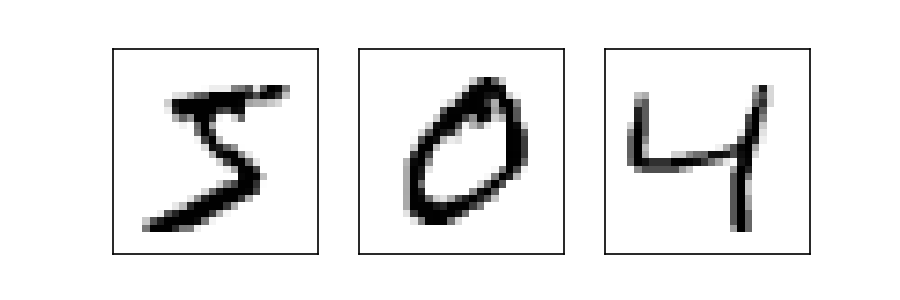

In [5]:
plot_triplets([x_train[0], x_train[1], x_train[2]])

### 4. A Batch of Triplets

In [6]:
def create_batch(batch_size=256):
    x_anchors = np.zeros((batch_size, 784))
    x_positives = np.zeros((batch_size, 784))
    x_negatives = np.zeros((batch_size, 784))
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_train.shape[0] - 1)
        x_anchor = x_train[random_index]
        y = y_train[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

<IPython.core.display.Javascript object>


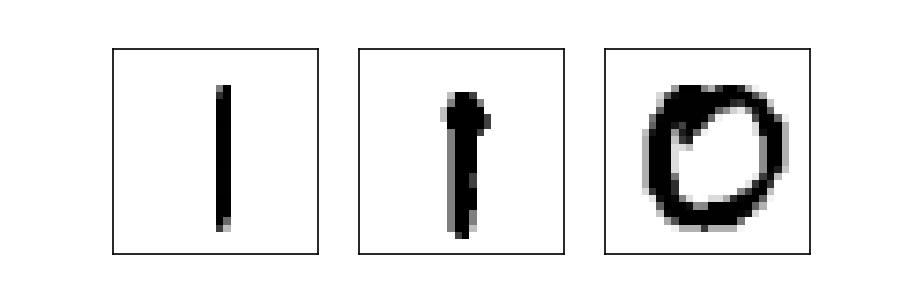

In [7]:
examples = create_batch(1)
plot_triplets(examples)

### 5. Embedding Model

In [8]:
emb_size = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(emb_size, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [9]:
example = np.expand_dims(x_train[0], axis=0)
example_emb = embedding_model.predict(example)[0]

print(example_emb)

[0.44118202 0.55670184 0.5137749  0.5032762  0.45620525 0.49418864
 0.45361608 0.58201873 0.49166194 0.52303445 0.4427408  0.4897527
 0.47526097 0.53748935 0.39583102 0.55615175 0.4219503  0.5173698
 0.61351466 0.5259522  0.5170519  0.53914577 0.5936984  0.40780985
 0.4700527  0.5542918  0.5278326  0.40163925 0.46792966 0.6124076
 0.5205405  0.4913921  0.54222983 0.5185131  0.51151735 0.49398783
 0.43379828 0.49924007 0.60195905 0.5324456  0.5525115  0.520673
 0.5176511  0.42211726 0.40855995 0.4310574  0.5132617  0.55682576
 0.5236173  0.68470126 0.5743178  0.4973991  0.5558146  0.50326556
 0.49217296 0.6454799  0.5047598  0.47040007 0.4800848  0.56278026
 0.44342095 0.5108224  0.6124659  0.484002  ]


### 6. Siamese Network

In [10]:
input_anchor = tf.keras.layers.Input(shape=(784,))
input_positive = tf.keras.layers.Input(shape=(784,))
input_negative = tf.keras.layers.Input(shape=(784,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           54400       input_1[0][0]                    
                                                                 input_2[0][0]         

### 7. Triplet Loss

In [11]:
alpha = 0.2

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

### 8. Data Generator

In [12]:
def data_generator(batch_size=256):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

### 9. Model Training

<IPython.core.display.Javascript object>


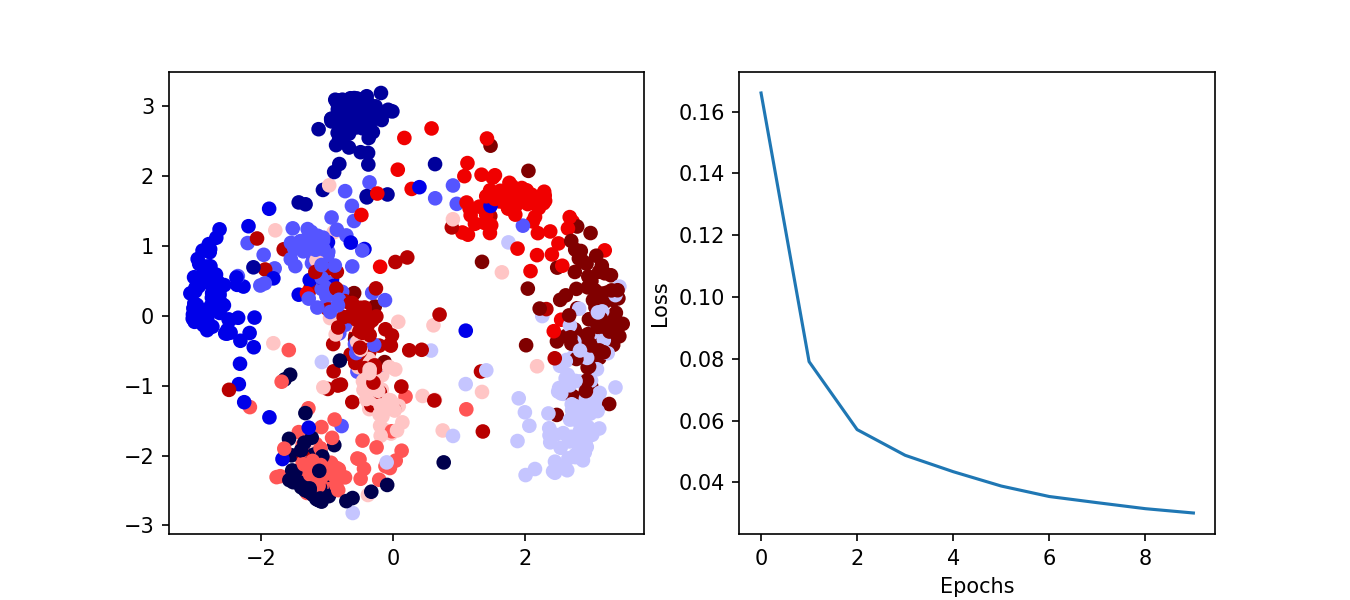

In [13]:
batch_size = 2048
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)

net.compile(loss=triplet_loss, optimizer='adam')

_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=False,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test[:1000], y_test[:1000]
        )]
)